# CS 109A/AC 209A/STAT 121A Data Science: Midterm I
**Harvard University**<br>
**Fall 2016**<br>
**Instructors: W. Pan, P. Protopapas, K. Rader**

---

### Basic Information

**Name:** Farmer, Rick

**Course Number:** CS 109a

**Note:** 

- _All data sets can be found in the `datasets` folder_

---

Import libraries

In [178]:
import time
import random
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import Ridge as Ridge_Reg
from sklearn.linear_model import Lasso as Lasso_Reg
from statsmodels.regression.linear_model import OLS
import sklearn.preprocessing as Preprocessing
import itertools as it
from itertools import combinations

from bs4 import BeautifulSoup
import urllib
# The "requests" library makes working with HTTP requests easier
# than the built-in urllib libraries
import requests

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors

from mpl_toolkits.mplot3d import Axes3D

from __future__ import division # Python 2.7 uses integer division by default, so that 5 / 2 equals 2, this sfixes that

%matplotlib inline

![Asteroid](https://github.com/cs109Alabs/lab_files/blob/master/astroid.gif?raw=true)

# Save the World! 



It is Oct 13, 2016. NASA's radars discovered a small, 3 meter, iron base meteorite that just entered the Earth's atmosphere.  A small meteorite will not create a wide-spread devastation but will still be dangerous for the citizens. Local authorities would like to know the location of the impact point so they that can warn residents and allocate resources based on the population affected.


The Governor has sought out the best data scientist in the state - you - to help save the day!

You are given two data sets:


1.  Radar position estimates (x, y, z - coordinates; z being the altitude) of the meteorite at various times are available here (https://cs109alabs.github.io/lab_files/). x, y, z coordinates are in kilometers and time is in seconds. 

2. Locations and other details of every dwelling in the town are provided herePreview the documentView in a new window.  


I. Using methods you learned in class to estimate the expected point of impact along with the region with 90% certainty.


II. Using the dwelling database, estimate the total number of people that will most likely be affected within this region.


AC209 students only: Additional measurements from another radar are available herePreview the documentView in a new window. The accuracy of this radar is approximately 5 times higher than that of the first radar. Your model should take into account both radar data sets.

## Load and Examine the Population Data

In [270]:
# Open the file containing the population data
pop_df = pd.read_csv('datasets/pop_data.csv')

# Display the dimensions of the data with a pretty format
print "Population data dimensions:"
print pop_df.shape
print "\n"

# Clean-up the Population data by filling missing values with the mean
pop_df.fillna(pop_df.mean())

# Display the first five rows of data
print "First five rows:"
pop_df.head(5)

Population data dimensions:
(2417, 5)


First five rows:


,residents,bed,bath,x,y
0,3.0,4,3,7201.60,6752.56
1,2.0,2,1,7079.68,6622.32
2,4.0,2,1,7154.40,6683.28
3,2.0,1,2,7093.44,6680.56
4,1.0,2,2,7198.72,6674.96


### Exploratory Data Visualization (Population)

[]

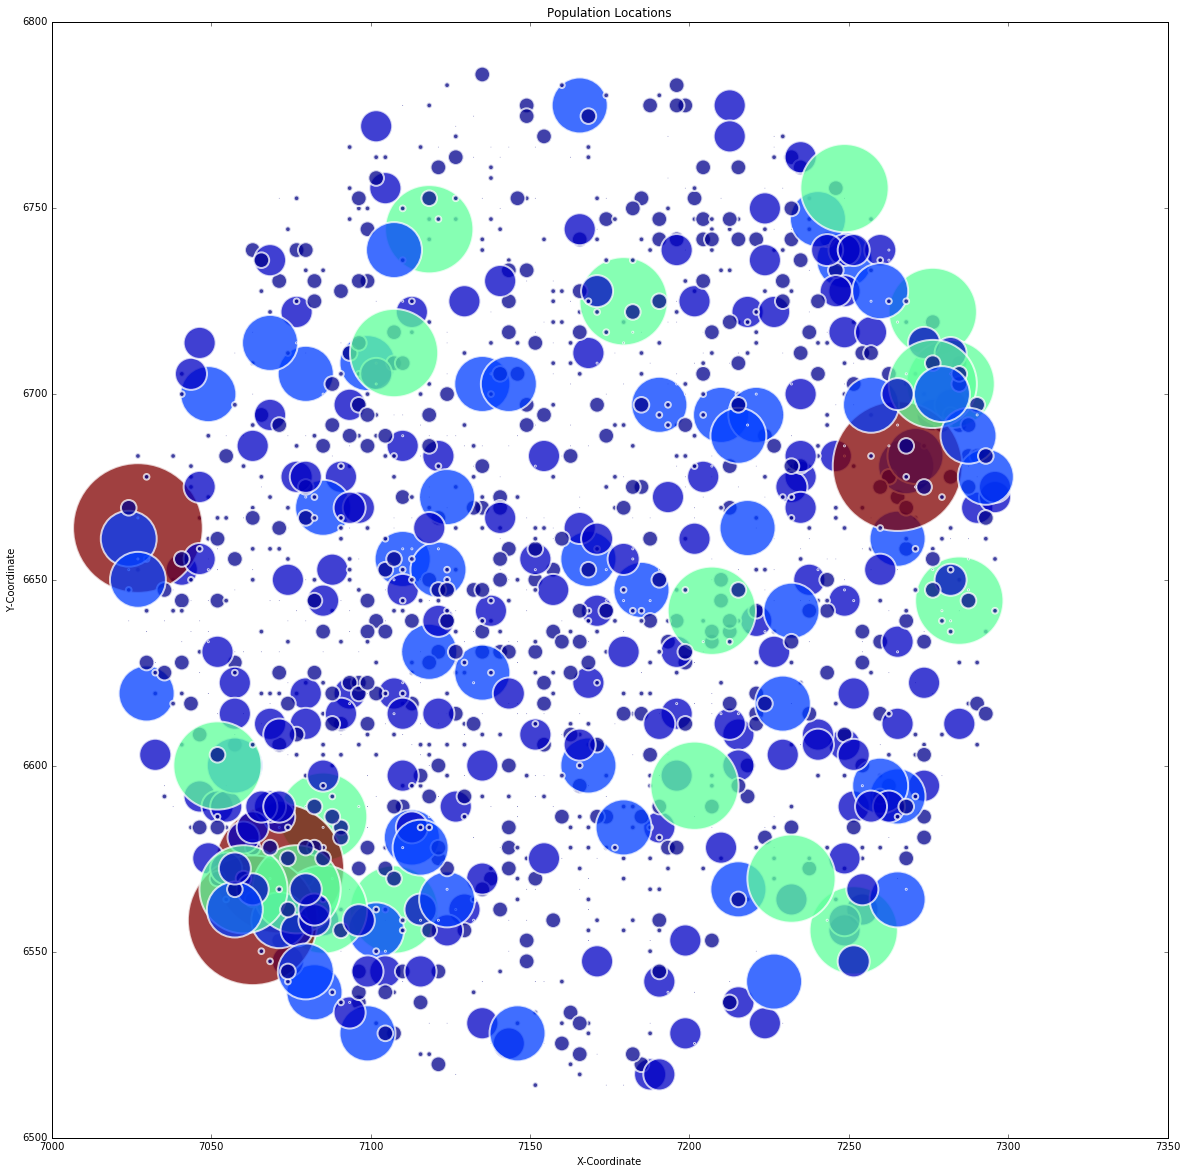

In [321]:
# Assign the residents in a geven area, and the coordinates for plotting
residents, pop_x, pop_y =  pop_df['residents']**5, pop_df['x'], pop_df['y']

# Create the figure ]
fig = plt.figure(figsize=(20,20))
ax1 = plt.axes()
ax1.scatter(pop_x, pop_y, s=residents, c=residents, linewidths=2, edgecolor='w').set_alpha(0.75)
ax1.set_xlabel('X-Coordinate')
ax1.set_ylabel('Y-Coordinate')
ax1.set_title('Population Locations')
plot()


## Load and Examine the Radar Position Data

In [232]:
# Get the Asteroid radar data from the lab repository on GitHub
radar = requests.get("https://raw.githubusercontent.com/cs109Alabs/lab_files/master/index.html")

# Use Beautiful Soup to parse the html text into a DOM object
soup = BeautifulSoup(radar.text, 'html.parser')

# Prettify the parse tree returned by Beautiful Soup
parse_tree = soup.prettify()

# Print the first 100 characters of the parse tree to see if it is there
print(parse_tree[:101])

<html>
 <head>
  <title>
   Save the World!
  </title>
 </head>
 <style type="text/css">
  .tg  {bord


In [200]:
# Let's make sure that our html element parsed correctly and that we are able to access them

# Display the text of the title tag
print "\n# Text of the <title> tag is:\n"
print soup.html.head.title.text

# Display each child of the head tag, first 200
print "\n\n# Each child of the <table> tag:"
print ''.join(map(str, soup.html.table.children))[:201]


# Text of the <title> tag is:

Save the World!


# Each child of the <table> tag:

<tr>
<th class="tg-yw4l">Time</th>
<th class="tg-yw4l">X-Coord</th>
<th class="tg-yw4l">Y-Coord</th>
<th class="tg-yw4l">Z-Coord</th>
</tr>
<tr>
<td class="tg-yw4l">0.000000000000000000e+00</td>
<td c


In [221]:
# Look for a single "table" element with a class of tg-yw4l;
# Then look for all the "tr" elements on that table
rows = soup.find("table").find_all("tr")[1:]

# We then define a function to act on
# each column's element in each row in the table to convert them to floats
def cleaner(r):
    time = float(r[0].get_text())
    x = float(r[1].get_text())
    y = float(r[2].get_text())
    z = float(r[3].get_text())
    return [time, x, y, z]

# Next we'll create a list of names that will be used as dictionary keys.
fields = ["time", "x", "y", "z"]

# The zip function creates a list of pairs; which the dict function then uses
# to create a dictionary, using the first element of the pair as the key and the second as
# the value; and finally, the list comprehension iterates over each row element, and puts
# the result of each iteration on a list, which is then bound to the radar variable.
radar = [dict(zip(fields, cleaner(row.find_all("td")))) for row in rows]

# Print the first three elements
radar[:3]

[{'time': 0.0,
  'x': 48.829114978261245,
  'y': 8.475320943737545,
  'z': 17005.09768524586},
 {'time': 10.0,
  'x': 69.15037477111318,
  'y': 69.21075417425614,
  'z': 16941.295532073807},
 {'time': 20.0,
  'x': 177.87772942855491,
  'y': 134.0117758000764,
  'z': 16831.33032964538}]

In [222]:
# We want to keep the radar data safe in case it becomes unavailable online at some point
import json

# Write the radar data to the local file system as a JSON file
fd = open("datasets/radar.json","w")
json.dump(radar, fd)
fd.close()

In [223]:
del radar # Remove the existing radar variable, so we can replace it with a dataframe

# Let's reload the data from the JSON file
radar_df = pd.read_json('datasets/radar.json')

# make sure it worked
print radar_df.shape
radar_df.head()

(130, 4)


,time,x,y,z
0,0,48.829115,8.475321,17005.097685
1,10,69.150375,69.210754,16941.295532
2,20,177.877729,134.011776,16831.330330
3,30,199.734002,220.743524,16569.077982
4,40,278.017526,221.403121,16849.673012


### Exploratory Data Visualization (Radar)

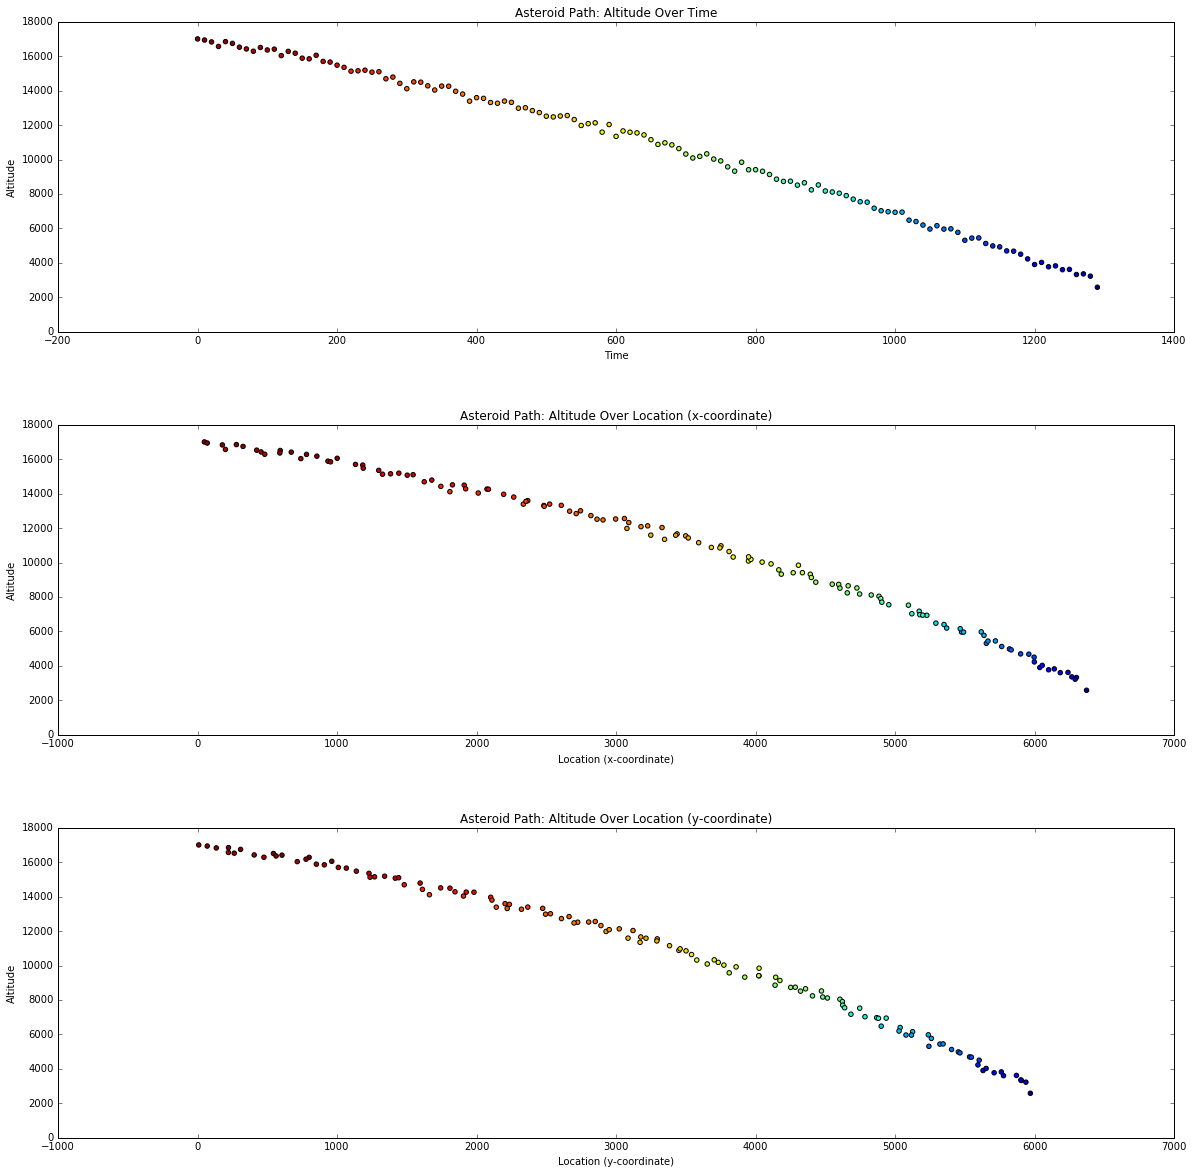

In [263]:
# Assign the coordinates for plotting
time, x, y, z =  radar_df['time'], radar_df['x'], radar_df['y'], radar_df['z']

# Create a new figure window to draw in, with a larger figure size to fill the space
fig = plt.figure(figsize=(20, 20)) 

# Add a subplot into the predefined 3 rows & 1 col figure for Altitude Over Time
ax = fig.add_subplot(3, 1, 1) 
ax.set_title("Asteroid Path: Altitude Over Time") # Add the title to each subplot
ax.set_xlabel("Time") # Add the x-axis label to this subplot
ax.set_ylabel("Altitude") # Add the y-axis label to this subplot

# Add a subplot into the predefined 3 rows & 1 col figure for Altitude Over Distance    
ax = fig.add_subplot(3, 1, 2)
ax.set_title("Asteroid Path: Altitude Over Location (x-coordinate)") # Add the title to each subplot
ax.set_xlabel("Location (x-coordinate)") # Add the x-axis label to this subplot
ax.set_ylabel("Altitude") # Add the y-axis label to this subplot    
    
# Add a subplot into the predefined 3 rows & 1 col figure for Altitude Over Distance    
ax = fig.add_subplot(3, 1, 3)
ax.set_title("Asteroid Path: Altitude Over Location (y-coordinate)") # Add the title to each subplot
ax.set_xlabel("Location (y-coordinate)") # Add the x-axis label to this subplot
ax.set_ylabel("Altitude") # Add the y-axis label to this subplot  
    
# Finally, add the x, y data in the form of a scatter plot and set the color scheme, e.g c=    
fig.axes[0].scatter(time, z, c=(time+z)) 
fig.axes[1].scatter(x, z, c=(x+z))
fig.axes[2].scatter(y, z, c=(y+z))

fig.subplots_adjust(wspace=0.1, hspace=0.3) # Spread out the subplots so they don't overlap one another

## Exploratory Data Visualization (Population + Radar Data)

Visualize the data using a 3-D scatter plot

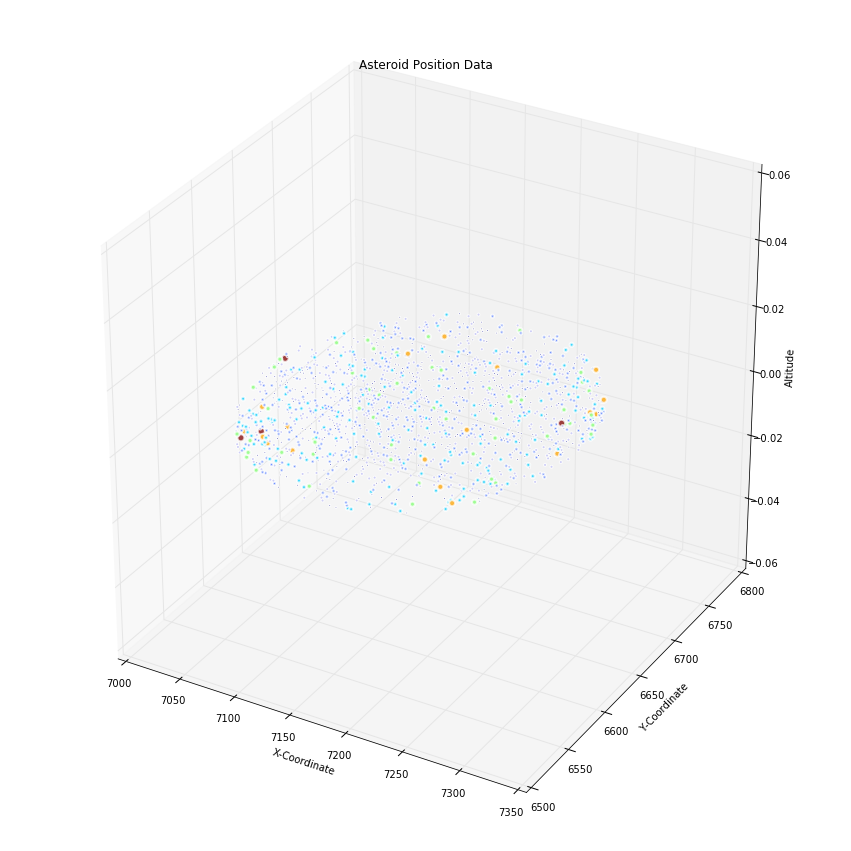

In [344]:
# Assign the coordinates for plotting radar data
time, x, y, z = radar_df['time'], radar_df['x'], radar_df['y'], radar_df['z']

# Assign the residents in a geven area, and the coordinates for plotting
residents, pop_x, pop_y =  pop_df['residents']**2, pop_df['x'], pop_df['y']

# Create a new figure window to draw in, with a larger figure size to fill the space
fig = plt.figure(figsize=(15, 15)) 

ax = plt.axes(projection='3d')
ax.set_title("Population Position Data")
ax.set_xlabel("X-Coordinate")
ax.set_ylabel("Y-Coordinate")
ax.set_zlabel("Altitude")

color = x - y - z

ax.scatter(pop_x, pop_y, 0, s=residents, c=residents, linewidths=2, edgecolor='w').set_alpha(0.75)



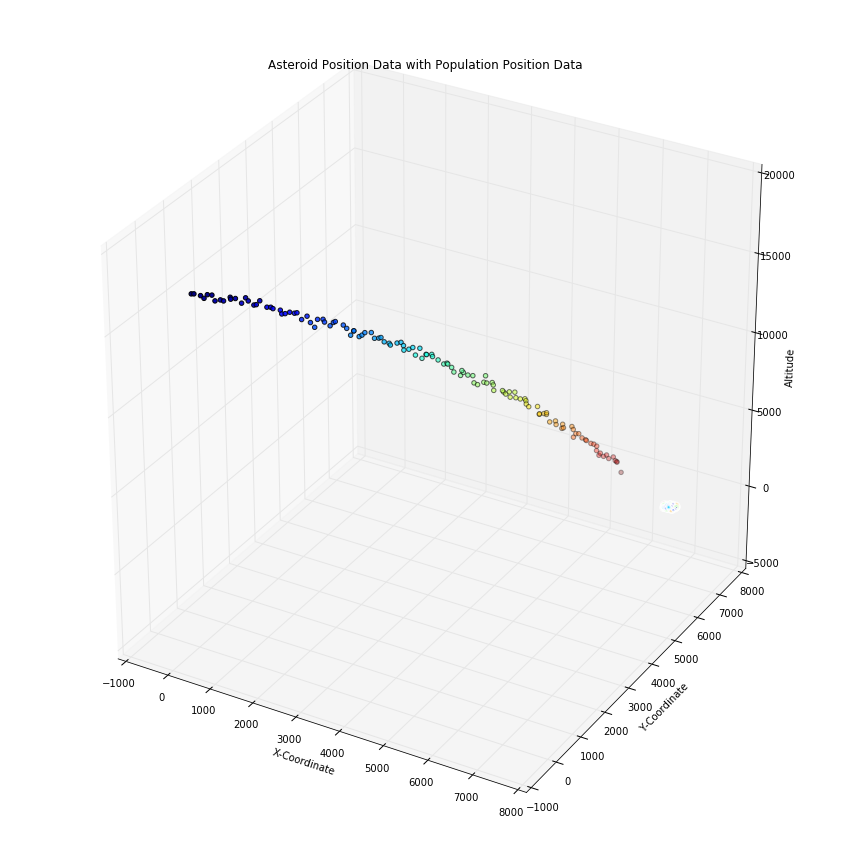

In [348]:
# Assign the coordinates for plotting radar data
time, x, y, z = radar_df['time'], radar_df['x'], radar_df['y'], radar_df['z']

# Assign the residents in a geven area, and the coordinates for plotting
residents, pop_x, pop_y =  pop_df['residents']**2, pop_df['x'], pop_df['y']

# Create a new figure window to draw in, with a larger figure size to fill the space
fig = plt.figure(figsize=(15, 15)) 

ax = plt.axes(projection='3d')
ax.set_title("Asteroid Position Data with Population Position Data")
ax.set_xlabel("X-Coordinate")
ax.set_ylabel("Y-Coordinate")
ax.set_zlabel("Altitude")

color = x - y - z

ax.scatter(pop_x, pop_y, 1, s=residents, c=residents, linewidths=2, edgecolor='w').set_alpha(0.75)
ax.scatter(x, y, z, c=color)

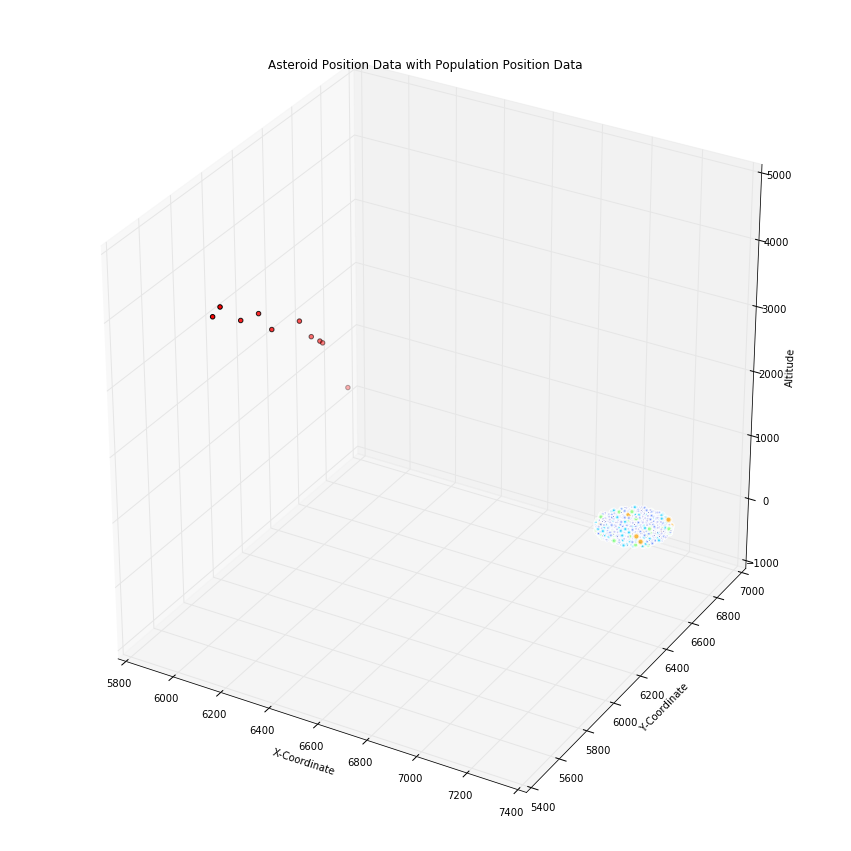

In [351]:
# Assign the coordinates for plotting radar data
time, x, y, z = radar_df['time'], radar_df['x'], radar_df['y'], radar_df['z']

# Assign the residents in a geven area, and the coordinates for plotting
residents, pop_x, pop_y =  pop_df['residents']**2, pop_df['x'], pop_df['y']

# Create a new figure window to draw in, with a larger figure size to fill the space
fig = plt.figure(figsize=(15, 15)) 

ax = plt.axes(projection='3d')
ax.set_title("Last 10 Asteroid Positions Relative to Population Location")
ax.set_xlabel("X-Coordinate")
ax.set_ylabel("Y-Coordinate")
ax.set_zlabel("Altitude")

color = x - y - z

ax.scatter(pop_x, pop_y, 1, s=residents, c=residents, linewidths=2, edgecolor='w').set_alpha(0.75)
ax.scatter(x[-10:], y[-10:], z[-10:], c='red')

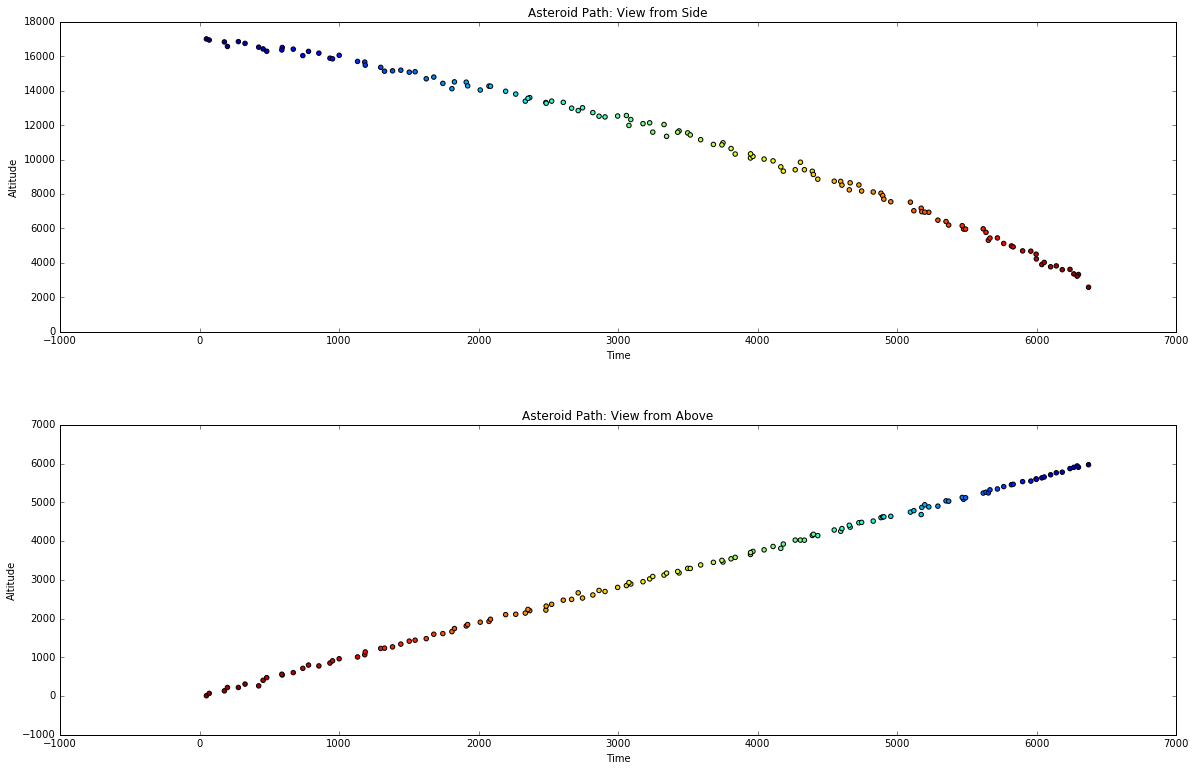

In [245]:
# Assign the coordinates for plotting
time, x, y, z =  radar_df['time'], radar_df['x'], radar_df['y'], radar_df['z']

# Create a title array for each plot we are going to create
plot_titles = ["Asteroid Path: View from Side", "Asteroid Path: View from Above"]

fig = plt.figure(figsize=(20, 20)) # Create a new figure window to draw in, with a larger figure size to fill the space

# We are lazy -- instead of creating an ax1, ax2, ax3 subplot, we just loop through 3 times to create them all at once
for i in range(2):
    ax = fig.add_subplot(3, 1, i + 1) # Add a subplot into the predefined 3 rows & 1 col figure, into position i (1, 2, or 3)
    ax.set_title(plot_titles[i]) # Add the title to each subplot from the plot_titles array
    ax.set_xlabel("Time") # Add the x-axis label to this subplot
    ax.set_ylabel("Altitude") # Add the y-axis label to this subplot

    
fig.axes[0].scatter(x, z, c=x) # Finally, add the x, y data in the form of a scatter plot and set the color scheme, e.g c=
fig.axes[1].scatter(x, y, c=z) # Repeat for x2, y2 data

fig.subplots_adjust(wspace=0.1, hspace=0.3) # Spread out the subplots so they don't overlap one another


### Where will the Asteroid Impact?

I. Using methods you learned in class to estimate the expected point of impact along with the region with 90% certainty.


### Number of People that will be Affected by Impact

II. Using the dwelling database, estimate the total number of people that will most likely be affected within this region.